<a href="https://colab.research.google.com/github/google/applied-machine-learning-intensive/blob/master/content/05_deep_learning/01_recurrent_neural_networks/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are an interesting application of deep learning that allow models to predict the future. While regression models attempt to fit an equation to existing data and extend the predictive power of the equation into the future, RNNs fit a model and use sequences of time series data to make step-by-step predictions about the next most likely output of the model.

In this colab we will create a recurrent neural network that can predict engine vibrations.

## Exploratory Data Analysis

We'll use the [Engine Vibrations data](https://www.kaggle.com/joshmcadams/engine-vibrations) from Kaggle. This dataset contains artificial engine vibration values we will use to train a model that can predict future values.

To load the data, upload your `kaggle.json` file and run the code block below.

In [1]:
#! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

kaggle.json     old-kaggle.json
Done


Next, download the data from Kaggle.

In [5]:
!kaggle datasets download joshmcadams/engine-vibrations
!ls

100%|███████████████████████████████████████| 90.0k/90.0k [00:00<00:00, 401kB/s]
100%|███████████████████████████████████████| 90.0k/90.0k [00:00<00:00, 400kB/s]
colab-key.zip         engine-vibrations.zip slides.md
colab.ipynb           kaggle.json           slides.pptx
content               res


Now load the data into a `DataFrame`.

In [6]:
import pandas as pd

df = pd.read_csv('engine-vibrations.zip')
df.describe()

,mm
count,10000.000000
mean,-0.000469
std,1.225200
min,-2.961817
25%,-0.872625
50%,0.040445
75%,0.876027
max,3.022369


We know the data contains readings of engine vibration over time. Let's see how that looks on a line chart.

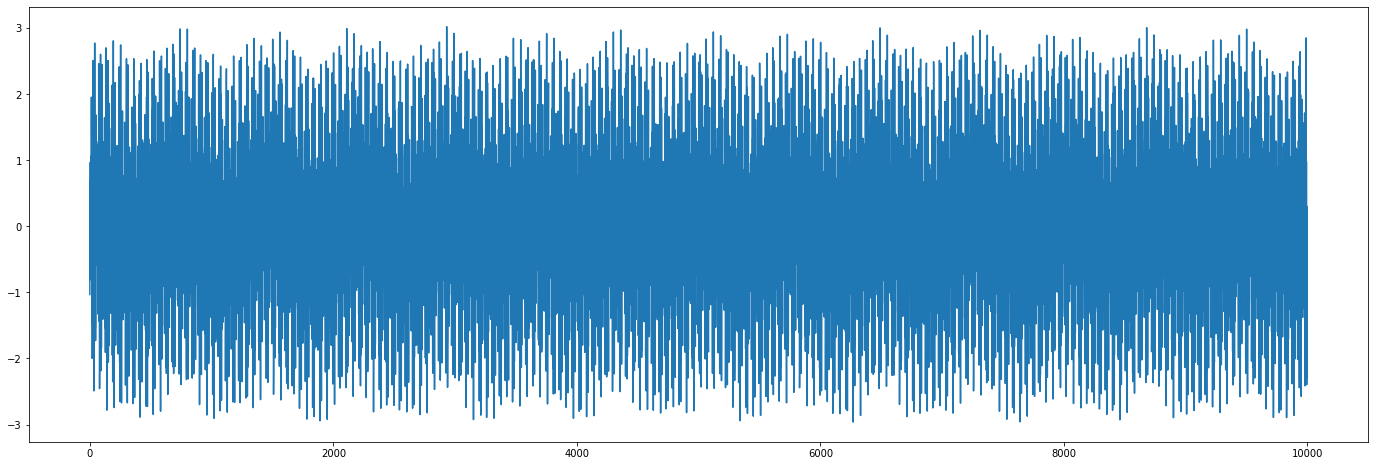

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
plt.plot(list(range(len(df['mm']))), df['mm'])
plt.show()

That's quite a tough chart to read. Let's sample it.

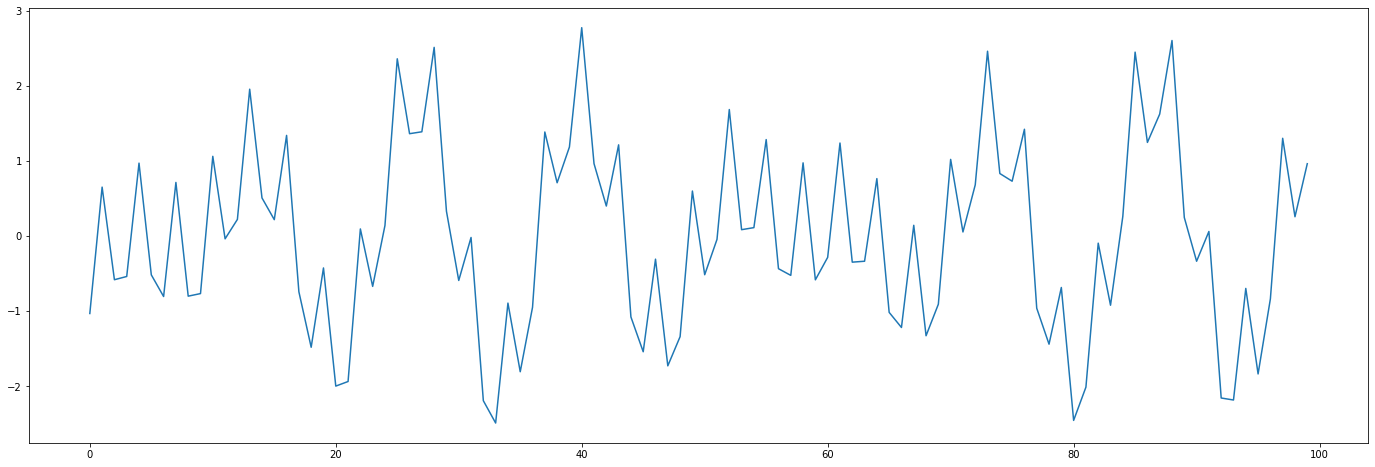

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
plt.plot(list(range(100)), df['mm'].iloc[:100])
plt.show()

See if any of the data is missing.

In [9]:
df.isna().any()

mm    False
dtype: bool

Finally, we'll do a box plot to see if the data is evenly distributed, which it is.

/Users/cgrant/.local/share/virtualenvs/2022-V6E0N3hn/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


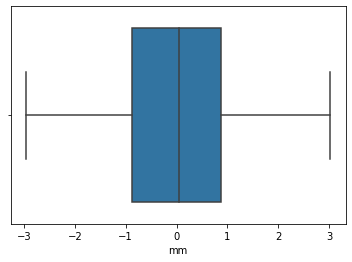

In [10]:
import seaborn as sns

_ = sns.boxplot(df['mm'])

There is not much more EDA we need to do at this point. Let's move on to modeling.

## Preparing the Data

Currently we have a series of data that contains a single list of vibration values over time. When training our model and when asking for predictions, we'll want to instead feed the model a subset of our sequence.

We first need to determine our subsequence length and then create in-order subsequences of that length.

We'll create a list of lists called `X` that contains subsequences. We'll also create a list called `y` that contains the next value after each subsequence stored in `X`.

In [11]:
import numpy as np

X = []
y = []
sseq_len = 50
for i in range(0, len(df['mm']) - sseq_len - 1):
  X.append(df['mm'][i:i+sseq_len])
  y.append(df['mm'][i+sseq_len+1])

y = np.array(y)
X = np.array(X)

X.shape, y.shape

((9949, 50), (9949,))

We also need to explicitly set the final dimension of the data in order to have it pass through our model.

In [12]:
X = np.expand_dims(X, axis=2)
y = np.expand_dims(y, axis=1)

X.shape, y.shape

((9949, 50, 1), (9949, 1))

We'll also standardize our data for the model. Note that we don't normalize here because we need to be able to reproduce negative values.

In [13]:
data_std = df['mm'].std()
data_mean = df['mm'].mean()

X = (X - data_mean) / data_std
y = (y - data_mean) / data_std

X.max(), y.max(), X.min(), y.min()

(2.4672209138882764,
 2.4672209138882764,
 -2.417033077681166,
 -2.417033077681166)

And for final testing after model training, we'll split off 20% of the data.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

## Setting a Baseline

We are only training with 50 data points at a time. This is well within the bounds of what a standard deep neural network can handle, so let's first see what a very simple neural network can do.

Epoch 1/50


2022-07-02 18:27:19.563095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


249/249 [==============================] - 0s 733us/step - loss: 1.2031 - mae: 0.7693 - mse: 1.2031
Epoch 2/50
249/249 [==============================] - 0s 720us/step - loss: 0.0026 - mae: 0.0386 - mse: 0.0026
Epoch 3/50
249/249 [==============================] - 0s 732us/step - loss: 0.0014 - mae: 0.0304 - mse: 0.0014
Epoch 4/50
249/249 [==============================] - 0s 733us/step - loss: 0.0014 - mae: 0.0304 - mse: 0.0014
Epoch 5/50
249/249 [==============================] - 0s 729us/step - loss: 0.0014 - mae: 0.0304 - mse: 0.0014
Epoch 6/50
63/63 [==============================] - 0s 554us/step
RMSE Scaled: 0.03797490183419372
RMSE Base Units: 0.046057641207884276


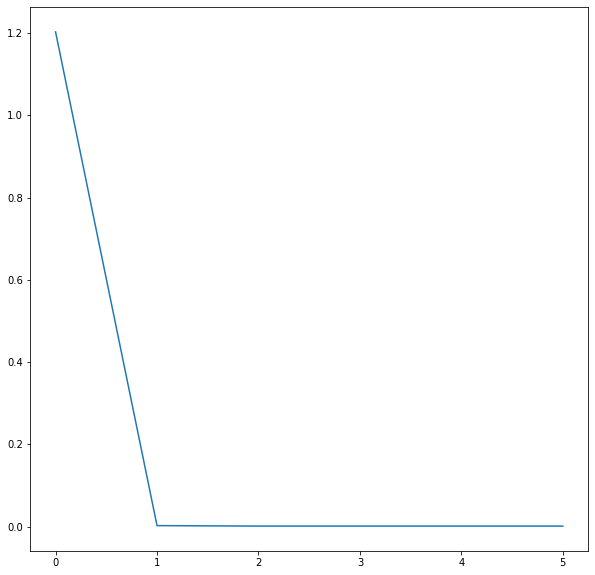

In [16]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

tf.random.set_seed(0)

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[sseq_len, 1]),
  keras.layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

We quickly converged and, when we ran the model, we got a baseline quality value of `0.03750885081060467`.

## The Most Basic RNN

Let's contrast a basic feedforward neural network with a basic RNN. To do this we simply need to use the [`SimpleRNN` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) in our network in place of the `Dense` layer in our network above. Notice that, in this case, there is no need to flatten the data before we feed it into the model.

Epoch 1/50
249/249 [==============================] - 2s 4ms/step - loss: 1.2727 - mae: 0.9109 - mse: 1.2727
Epoch 2/50
249/249 [==============================] - 1s 4ms/step - loss: 0.8941 - mae: 0.7715 - mse: 0.8941
Epoch 3/50
249/249 [==============================] - 1s 4ms/step - loss: 0.7938 - mae: 0.7277 - mse: 0.7938
Epoch 4/50
249/249 [==============================] - 1s 4ms/step - loss: 0.7881 - mae: 0.7249 - mse: 0.7881
Epoch 5/50
249/249 [==============================] - 1s 4ms/step - loss: 0.7891 - mae: 0.7244 - mse: 0.7891
Epoch 6/50
249/249 [==============================] - 1s 4ms/step - loss: 0.7873 - mae: 0.7248 - mse: 0.7873
Epoch 7/50
249/249 [==============================] - 1s 4ms/step - loss: 0.7873 - mae: 0.7249 - mse: 0.7873
Epoch 8/50
249/249 [==============================] - 1s 4ms/step - loss: 0.7876 - mae: 0.7252 - mse: 0.7876
Epoch 9/50
63/63 [==============================] - 0s 2ms/step
RMSE Scaled: 0.8998073252429559
RMSE Base Units: 1.1019743008137

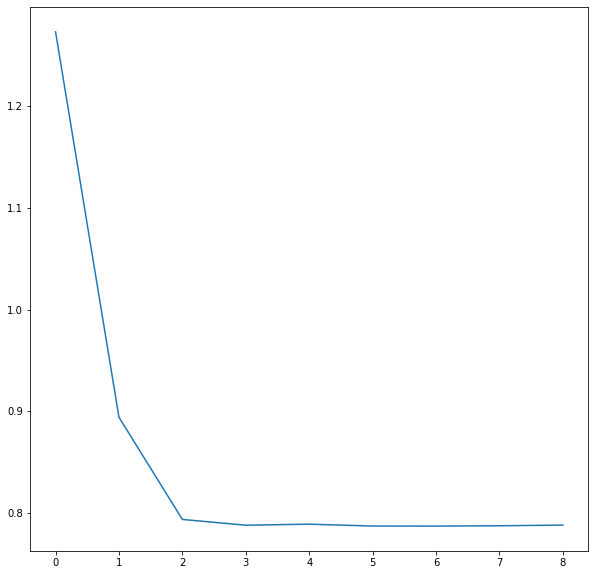

In [17]:
tf.random.set_seed(0)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

Our model converged a little more slowly, but it got an error of only `0.8974118571865628`, which is not an improvement over the baseline model.

## A Deep RNN

Let's try to build a deep RNN and see if we can get better results.

In the model below, we stick together four layers ranging in width from `50` nodes to our final output of `1`.

Notice all of the layers except the output layer have `return_sequences=True` set. This causes the layer to pass outputs for all timestamps to the next layer. If you don't include this argument, only the output for the last timestamp is passed, and intermediate layers will complain about the wrong shape of input.

Epoch 1/50
249/249 [==============================] - 7s 20ms/step - loss: 0.1836 - mae: 0.2906 - mse: 0.1836
Epoch 2/50
249/249 [==============================] - 5s 20ms/step - loss: 0.1423 - mae: 0.2340 - mse: 0.1423
Epoch 3/50
249/249 [==============================] - 7s 29ms/step - loss: 0.1385 - mae: 0.2242 - mse: 0.1385
Epoch 4/50
249/249 [==============================] - 11s 42ms/step - loss: 0.1361 - mae: 0.2163 - mse: 0.1361
Epoch 5/50
249/249 [==============================] - 11s 46ms/step - loss: 0.1350 - mae: 0.2128 - mse: 0.1350
Epoch 6/50
249/249 [==============================] - 10s 40ms/step - loss: 0.1344 - mae: 0.2110 - mse: 0.1344
Epoch 7/50
249/249 [==============================] - 15s 59ms/step - loss: 0.1337 - mae: 0.2078 - mse: 0.1337
Epoch 8/50
249/249 [==============================] - 13s 52ms/step - loss: 0.1336 - mae: 0.2081 - mse: 0.1336
Epoch 9/50
249/249 [==============================] - 11s 46ms/step - loss: 0.1332 - mae: 0.2064 - mse: 0.1332
Epoc

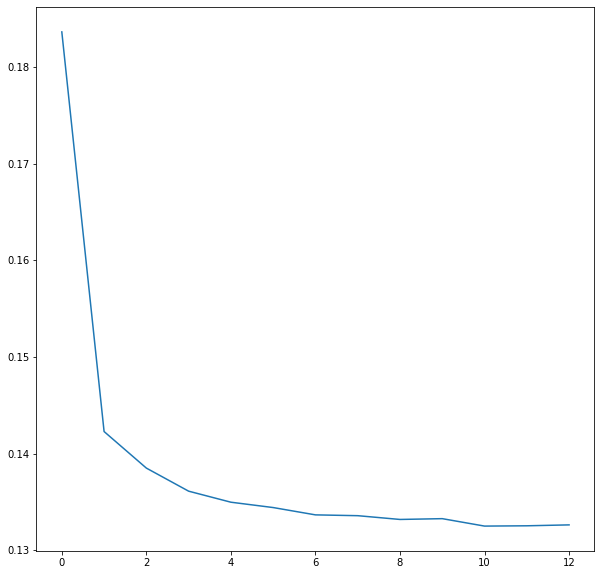

In [18]:
tf.random.set_seed(0)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

Woah! What happened? Our MSE during training looked nice: `0.0496`. But our final testing didn't perform much better than our simple model. We seem to have overfit!

We can try to simplify the model and add dropout layers to reduce overfitting, but even with a very basic model like the one below, we still get very different MSE between the training and test datasets.

Epoch 1/50
249/249 [==============================] - 3s 9ms/step - loss: 1.9421 - mae: 1.1363 - mse: 1.9421
Epoch 2/50
249/249 [==============================] - 2s 9ms/step - loss: 0.9194 - mae: 0.7731 - mse: 0.9194
Epoch 3/50
249/249 [==============================] - 2s 9ms/step - loss: 0.7187 - mae: 0.6873 - mse: 0.7187
Epoch 4/50
249/249 [==============================] - 2s 9ms/step - loss: 0.6183 - mae: 0.6476 - mse: 0.6183
Epoch 5/50
249/249 [==============================] - 2s 9ms/step - loss: 0.5749 - mae: 0.6275 - mse: 0.5749
Epoch 6/50
249/249 [==============================] - 2s 9ms/step - loss: 0.5408 - mae: 0.6104 - mse: 0.5408
Epoch 7/50
249/249 [==============================] - 3s 10ms/step - loss: 0.5311 - mae: 0.6072 - mse: 0.5311
Epoch 8/50
249/249 [==============================] - 3s 11ms/step - loss: 0.5256 - mae: 0.6074 - mse: 0.5256
Epoch 9/50
249/249 [==============================] - 3s 12ms/step - loss: 0.5199 - mae: 0.6042 - mse: 0.5199
Epoch 10/50
249/

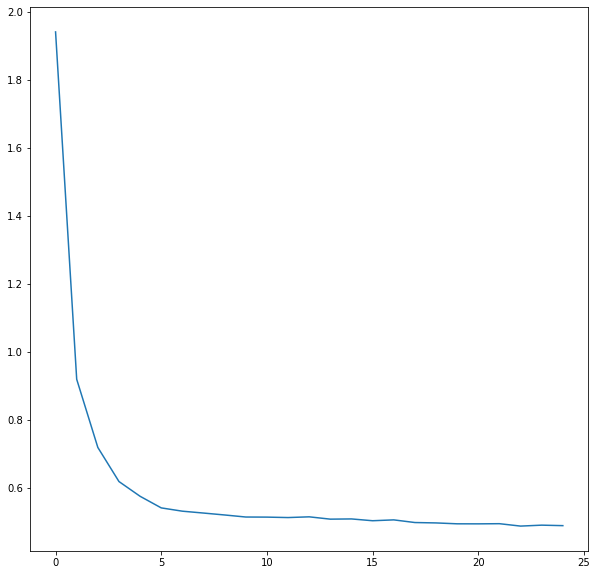

In [19]:
tf.random.set_seed(0)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(2, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.3),
    keras.layers.SimpleRNN(1),
    keras.layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

Even with these measures, we still seem to be overfitting a bit. We could keep tuning, but let's instead look at some other types of neurons found in RNNs.

## Long Short Term Memory

The RNN layers we've been using are basic neurons that have a very short memory. They tend to learn patterns that they have recently seen, but they quickly forget older training data.

The **Long Short Term Memory (LSTM)** neuron was built to combat this forgetfulness. The neuron outputs values for the next layer in the network, and it also outputs two other values: one for short-term memory and one for long-term memory. These weights are then fed back into the neuron at the next iteration of the network. This backfeed is similar to that of a `SimpleRNN`, except the `SimpleRNN` only has one backfeed.

We can replace the `SimpleRNN` with an `LSTM` layer, as you can see below.

Epoch 1/100
249/249 [==============================] - 3s 9ms/step - loss: 0.9902 - mae: 0.8162 - mse: 0.9902
Epoch 2/100
249/249 [==============================] - 2s 9ms/step - loss: 0.9667 - mae: 0.8066 - mse: 0.9667
Epoch 3/100
249/249 [==============================] - 2s 8ms/step - loss: 0.9465 - mae: 0.7982 - mse: 0.9465
Epoch 4/100
249/249 [==============================] - 2s 8ms/step - loss: 0.9387 - mae: 0.7945 - mse: 0.9387
Epoch 5/100
249/249 [==============================] - 2s 8ms/step - loss: 0.9360 - mae: 0.7932 - mse: 0.9360
Epoch 6/100
249/249 [==============================] - 2s 8ms/step - loss: 0.9347 - mae: 0.7926 - mse: 0.9347
Epoch 7/100
249/249 [==============================] - 2s 9ms/step - loss: 0.9338 - mae: 0.7921 - mse: 0.9338
Epoch 8/100
249/249 [==============================] - 2s 10ms/step - loss: 0.9330 - mae: 0.7917 - mse: 0.9330
Epoch 9/100
249/249 [==============================] - 2s 9ms/step - loss: 0.9322 - mae: 0.7912 - mse: 0.9322
Epoch 10/

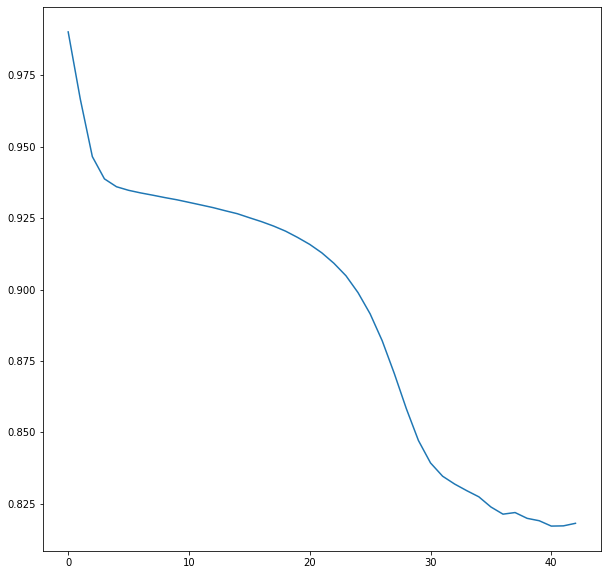

In [20]:
tf.random.set_seed(0)

model = keras.models.Sequential([
    keras.layers.LSTM(1, input_shape=[None, 1]),
])

model.compile(
  loss='mse',
  optimizer=tf.keras.optimizers.Adam(),
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=100, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

We got a test RMSE of `0.8989123704842217`, which is still not better than our `SimpleRNN`. And in the more complex model below, we got close to the baseline but still didn't beat it.

Epoch 1/50
249/249 [==============================] - 8s 19ms/step - loss: 0.5472 - mae: 0.6145 - mse: 0.5472
Epoch 2/50
249/249 [==============================] - 5s 20ms/step - loss: 0.4151 - mae: 0.5534 - mse: 0.4151
Epoch 3/50
249/249 [==============================] - 6s 23ms/step - loss: 0.3092 - mae: 0.4795 - mse: 0.3092
Epoch 4/50
249/249 [==============================] - 7s 27ms/step - loss: 0.2909 - mae: 0.4635 - mse: 0.2909
Epoch 5/50
249/249 [==============================] - 7s 30ms/step - loss: 0.2741 - mae: 0.4484 - mse: 0.2741
Epoch 6/50
249/249 [==============================] - 8s 32ms/step - loss: 0.2621 - mae: 0.4353 - mse: 0.2621
Epoch 7/50
249/249 [==============================] - 8s 32ms/step - loss: 0.2501 - mae: 0.4242 - mse: 0.2501
Epoch 8/50
249/249 [==============================] - 8s 33ms/step - loss: 0.2398 - mae: 0.4118 - mse: 0.2398
Epoch 9/50
249/249 [==============================] - 8s 34ms/step - loss: 0.2322 - mae: 0.4041 - mse: 0.2322
Epoch 10/5

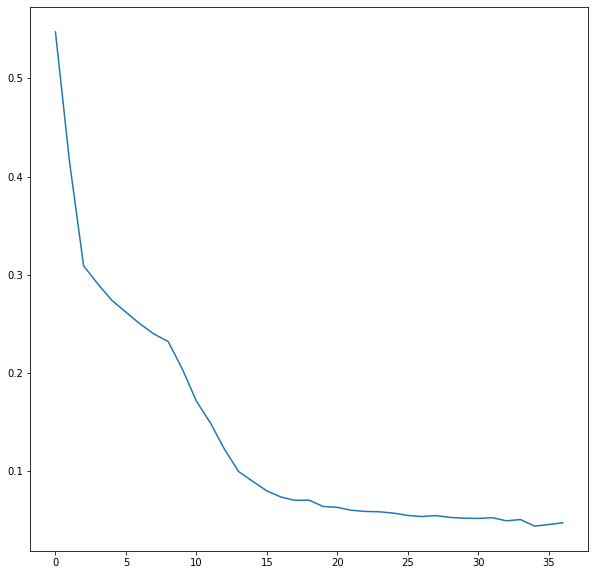

In [21]:
tf.random.set_seed(0)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(10),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

LSTM neurons can be very useful, but as we have seen, they aren't always the best option.

Let's look at one more neuron commonly found in RNN models, the GRU.

## Gated Recurrent Unit

The Gated Recurrent Unit (GRU) is another special neuron that often shows up in Recurrent Neural Networks. The GRU is similar to the LSTM in that it feeds output back into itself. The difference is that the GRU feeds a single weight back into itself and then makes long- and short-term state adjustments based on that single backfeed.

The GRU tends to train faster than LSTM and has similar performance. Let's see how a network containing one GRU performs.

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10 µs
Epoch 1/50
249/249 [==============================] - 6s 15ms/step - loss: 0.9586 - mae: 0.8023 - mse: 0.9586
Epoch 2/50
249/249 [==============================] - 4s 15ms/step - loss: 0.9379 - mae: 0.7935 - mse: 0.9379
Epoch 3/50
249/249 [==============================] - 4s 15ms/step - loss: 0.9337 - mae: 0.7920 - mse: 0.9337
Epoch 4/50
249/249 [==============================] - 4s 15ms/step - loss: 0.9329 - mae: 0.7918 - mse: 0.9329
Epoch 5/50
249/249 [==============================] - 4s 15ms/step - loss: 0.9326 - mae: 0.7917 - mse: 0.9326
Epoch 6/50
249/249 [==============================] - 4s 14ms/step - loss: 0.9324 - mae: 0.7916 - mse: 0.9324
Epoch 7/50
249/249 [==============================] - 4s 14ms/step - loss: 0.9323 - mae: 0.7915 - mse: 0.9323
Epoch 8/50
249/249 [==============================] - 4s 14ms/step - loss: 0.9322 - mae: 0.7915 - mse: 0.9322
Epoch 9/50
249/249 [==============================] - 3s 1

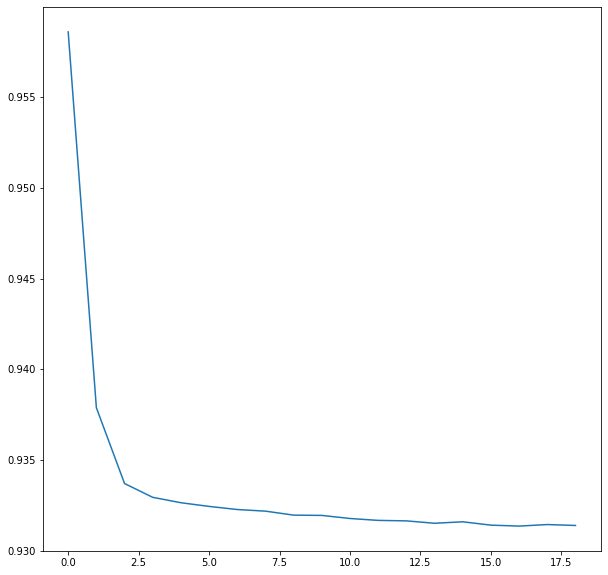

In [22]:
%time
tf.random.set_seed(0)

model = keras.models.Sequential([
    keras.layers.GRU(1),
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

We got a RMSE of `0.9668634342193015`, which isn't bad, but it still performs worse than our baseline.

## Convolutional Layers

Convolutional layers are limited to image classification models. They can also be really handy when training RNNs. For training on a sequence of data, we use the [`Conv1D` class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) as shown below.

Epoch 1/50
249/249 [==============================] - 3s 6ms/step - loss: 0.6635 - mae: 0.6302 - mse: 0.6635
Epoch 2/50
249/249 [==============================] - 1s 6ms/step - loss: 0.4252 - mae: 0.4842 - mse: 0.4252
Epoch 3/50
249/249 [==============================] - 1s 6ms/step - loss: 0.3557 - mae: 0.4363 - mse: 0.3557
Epoch 4/50
249/249 [==============================] - 1s 6ms/step - loss: 0.3249 - mae: 0.4155 - mse: 0.3249
Epoch 5/50
249/249 [==============================] - 1s 6ms/step - loss: 0.3159 - mae: 0.4074 - mse: 0.3159
Epoch 6/50
249/249 [==============================] - 1s 6ms/step - loss: 0.3001 - mae: 0.3965 - mse: 0.3001
Epoch 7/50
249/249 [==============================] - 1s 6ms/step - loss: 0.2928 - mae: 0.3934 - mse: 0.2928
Epoch 8/50
249/249 [==============================] - 1s 6ms/step - loss: 0.2955 - mae: 0.3947 - mse: 0.2955
Epoch 9/50
63/63 [==============================] - 0s 2ms/step
RMSE Scaled: 0.4074751097736273
RMSE Base Units: 0.4987691135239

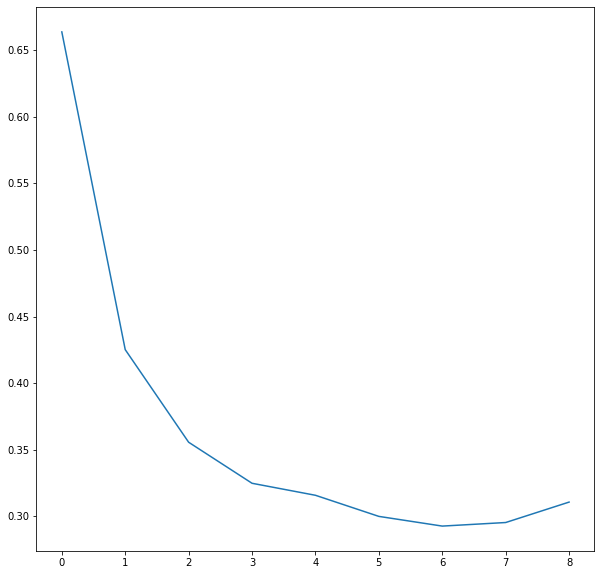

In [23]:
tf.random.set_seed(0)


model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(2, input_shape=[None, 1], activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1),
])

model.compile(
  loss='mse',
  optimizer='Adam',
  metrics=['mae', 'mse'],
)

stopping = tf.keras.callbacks.EarlyStopping(
  monitor='loss',
  min_delta=0,
  patience=2)

history = model.fit(X_train, y_train, epochs=50, callbacks=[stopping])

y_pred = model.predict(X_test)
rmse = math.sqrt(np.mean(keras.losses.mean_squared_error(y_test, y_pred)))
print("RMSE Scaled: {}\nRMSE Base Units: {}".format(
    rmse, rmse * data_std + data_mean))

plt.figure(figsize=(10,10))
plt.plot(list(range(len(history.history['mse']))), history.history['mse'])
plt.show()

Recurrent Neural Networks are a powerful tool for sequence generation and prediction. But they aren't the only mechanism for sequence prediction. If the sequence you are predicting is short enough, then a standard deep neural network might be able to provide the predictions you are looking for.

Also note that we created a model that took a series of data and output one value. It is possible to create RNNs that input one or more values and output one or more values. Each use case is different.

# Exercises

## Exercise 1: Visualization

Create a plot containing a series of at least 50 predicted points. Plot that series against the actual.

> *Hint: Pick a sequence of 100 values from the original data. Plot data points 50-100 as the actual line. Then predict 50 single values starting with the features 0-49, 1-50, etc.*

### **Student Solution**

In [0]:
# Your code goes here

---

## Exercise 2: Stock Price Prediction

Using the [`Stonks!`](https://www.kaggle.com/joshmcadams/stonks) dataset, create a recurrent neural network that can predict the stock price for the 'AAA' ticker. Calculate your RMSE with some holdout data.

Use as many text and code cells as you need to complete this exercise.

> *Hint: if predicting absolute prices doesn't yield a good model, look into other ways to represent the day-to-day change in data.*

In [0]:
# Your code goes here

---